# Use torch.nn.LSTM module

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from tensorboardX import SummaryWriter
import torchvision.models as models
import torchvision.utils as vutils
from torchvision import datasets
%matplotlib inline

In [2]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import unicodedata
import string
import torch.nn as nn
import torch

In [3]:
def findFiles(path): return glob.glob(path)

In [4]:
print(findFiles('../data/names/*.txt'))

['../data/names\\Arabic.txt', '../data/names\\Chinese.txt', '../data/names\\Czech.txt', '../data/names\\Dutch.txt', '../data/names\\English.txt', '../data/names\\French.txt', '../data/names\\German.txt', '../data/names\\Greek.txt', '../data/names\\Irish.txt', '../data/names\\Italian.txt', '../data/names\\Japanese.txt', '../data/names\\Korean.txt', '../data/names\\Polish.txt', '../data/names\\Portuguese.txt', '../data/names\\Russian.txt', '../data/names\\Scottish.txt', '../data/names\\Spanish.txt', '../data/names\\Vietnamese.txt']


In [5]:
all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

In [6]:
all_letters

"abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ .,;'"

In [7]:
n_letters

57

In [8]:
import unidecode
print(unidecode.unidecode('Ślusàrski'))

Slusarski


In [9]:
print(unidecode.unidecode('嬴政'))

Ying Zheng 


In [10]:
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

Slusarski


In [11]:
# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

In [12]:
# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('../data/names/*.txt'):
    category = filename.split('/')[-1].split('.')[0].split('\\')[-1]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

In [13]:
print(category_lines['Italian'][:5])

['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']


In [14]:
import torch

# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('J'))

print(lineToTensor('Jones').size())

tensor([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])
torch.Size([5, 1, 57])


In [15]:
print(letterToTensor('J'))

tensor([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])


In [16]:
print(lineToTensor('Jones').size())

torch.Size([5, 1, 57])


Creating the Network
====================

Training
========
Preparing for Training
----------------------

In [17]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

#print(categoryFromOutput(output))

In [29]:
all_categories

['Arabic',
 'Chinese',
 'Czech',
 'Dutch',
 'English',
 'French',
 'German',
 'Greek',
 'Irish',
 'Italian',
 'Japanese',
 'Korean',
 'Polish',
 'Portuguese',
 'Russian',
 'Scottish',
 'Spanish',
 'Vietnamese']

In [31]:
randomChoice(category_lines[category])

'Meisner'

In [32]:
randomTrainingExample()

('Italian',
 'Brambilla',
 tensor([ 9]),
 tensor([[[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
            0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
            0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,
            0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
            0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
            0.,  0.]],
 
         [[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
            0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,
            0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
            0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
            0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
            0.,  0.]],
 
         [[ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
            0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
            0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
            0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 

In [18]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = Vietnamese / line = Luu
category = Greek / line = Belesis
category = Portuguese / line = Cruz
category = Italian / line = Viola
category = Scottish / line = Boyle
category = Russian / line = Valyavsky
category = Portuguese / line = Castro
category = Greek / line = Kaglantge
category = Korean / line = Pae
category = Dutch / line = Roggeveen


Plotting the Results
--------------------

In [19]:
>>> rnn = nn.RNN(10, 20, 2)
>>> input = torch.randn(5, 3, 10)
>>> h0 = torch.randn(2, 3, 20)
>>> output, hn = rnn(input, h0)

In [20]:
>>> rnn = nn.RNN(53, 100, 1)
>>> input = torch.randn(5, 1, 53)
>>> h0 = torch.randn(1, 1, 100)
>>> output, hn = rnn(input, h0)

In [21]:
>>> rnn = nn.LSTM(10, 20, 2)
>>> input = torch.randn(5, 3, 10)
>>> h0 = torch.randn(2, 3, 20)
>>> c0 = torch.randn(2, 3, 20)
>>> output, (hn, cn) = rnn(input, (h0, c0))

In [22]:
>>> rnn = nn.LSTM(53, 100, 1)
>>> input = torch.randn(5, 1, 53)
>>> h0 = torch.randn(1, 1, 100)
>>> c0 = torch.randn(1, 1, 100)
>>> output, (hn, cn) = rnn(input, (h0, c0))

In [23]:
output[4]

tensor([[ 0.1162,  0.1647, -0.0246, -0.0358, -0.0710, -0.0044,  0.0910,
          0.0657,  0.0500, -0.0468, -0.1970, -0.0490, -0.2695, -0.0639,
          0.0052,  0.1088, -0.1789,  0.2280, -0.0501,  0.0091, -0.0365,
          0.0461,  0.2685, -0.0184, -0.0024, -0.1182,  0.1317,  0.0118,
          0.0412, -0.0822, -0.0294,  0.0408,  0.1818,  0.0786, -0.0069,
         -0.0500,  0.0166,  0.0432, -0.0936,  0.1336, -0.0856,  0.0202,
          0.0165, -0.0262, -0.0417, -0.0548, -0.1506,  0.1075,  0.1555,
         -0.1277, -0.0213,  0.0997,  0.3413, -0.2050,  0.1264,  0.0200,
          0.0722, -0.0218,  0.0079, -0.0651, -0.2083,  0.0967, -0.1058,
          0.0060,  0.0895, -0.1761,  0.1327, -0.0523,  0.0450,  0.1142,
         -0.1446,  0.2324, -0.0900, -0.0167,  0.0023, -0.0655,  0.1894,
          0.0545,  0.1469, -0.0841, -0.0378, -0.0767, -0.0188,  0.0288,
          0.0402, -0.0506, -0.1844, -0.0321, -0.1715, -0.1072, -0.0045,
         -0.1275, -0.0581,  0.0457,  0.0050, -0.0159, -0.1911,  

In [24]:
hn

tensor([[[ 0.1162,  0.1647, -0.0246, -0.0358, -0.0710, -0.0044,  0.0910,
           0.0657,  0.0500, -0.0468, -0.1970, -0.0490, -0.2695, -0.0639,
           0.0052,  0.1088, -0.1789,  0.2280, -0.0501,  0.0091, -0.0365,
           0.0461,  0.2685, -0.0184, -0.0024, -0.1182,  0.1317,  0.0118,
           0.0412, -0.0822, -0.0294,  0.0408,  0.1818,  0.0786, -0.0069,
          -0.0500,  0.0166,  0.0432, -0.0936,  0.1336, -0.0856,  0.0202,
           0.0165, -0.0262, -0.0417, -0.0548, -0.1506,  0.1075,  0.1555,
          -0.1277, -0.0213,  0.0997,  0.3413, -0.2050,  0.1264,  0.0200,
           0.0722, -0.0218,  0.0079, -0.0651, -0.2083,  0.0967, -0.1058,
           0.0060,  0.0895, -0.1761,  0.1327, -0.0523,  0.0450,  0.1142,
          -0.1446,  0.2324, -0.0900, -0.0167,  0.0023, -0.0655,  0.1894,
           0.0545,  0.1469, -0.0841, -0.0378, -0.0767, -0.0188,  0.0288,
           0.0402, -0.0506, -0.1844, -0.0321, -0.1715, -0.1072, -0.0045,
          -0.1275, -0.0581,  0.0457,  0.0050, -0.01

In [25]:
class nn_LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        
    def forward(self, X, hidden):
        _, hidden = self.lstm(X, hidden)
        output = self.out(hidden[0])
        return output, hidden
    
    def initHidden(self):
        return (torch.zeros(1, 1, self.hidden_size),
                torch.zeros(1, 1, self.hidden_size)
               )

In [26]:
rnn = nn_LSTM(n_letters, 128, n_categories)

In [27]:
criterion = nn.CrossEntropyLoss()
#optimizer = torch.optim.RMSprop(rnn.parameters(), lr=0.001)
optimizer = torch.optim.SGD(rnn.parameters(), lr=0.005)

In [28]:
def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    optimizer.zero_grad()

    output, hidden = rnn(line_tensor, hidden)

    loss = criterion(output.view(-1,n_categories), category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    
    optimizer.step()

    return output, loss.item()

In [74]:
writer = SummaryWriter('logs/lstm1')

In [33]:
category, line, category_tensor, line_tensor = randomTrainingExample()

In [34]:
category, line

('Dutch', 'Kann')

In [36]:
category_tensor.shape

torch.Size([1])

In [37]:
line_tensor.shape

torch.Size([4, 1, 57])

In [78]:
import time
import math

n_iters = 500000
print_every = 5000
plot_every = 1000

# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(0, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        writer.add_scalar('loss', current_loss / plot_every, iter)
        current_loss = 0

0 0% (0m 0s) 2.9364 Voclain / Irish ✗ (French)
5000 1% (0m 25s) 2.8712 Hanzlik / Polish ✗ (Czech)
10000 2% (0m 44s) 2.8253 Paiser / German ✗ (Czech)
15000 3% (1m 47s) 2.8740 Tosell / English ✗ (Spanish)
20000 4% (2m 36s) 2.7540 Petrezelka / Japanese ✗ (Czech)
25000 5% (2m 51s) 2.7793 Abadi / Japanese ✗ (Arabic)
30000 6% (4m 21s) 2.7156 Treblik / French ✗ (Czech)
35000 7% (4m 53s) 1.3201 Rang / Chinese ✓
40000 8% (6m 11s) 2.2696 Katschker / Dutch ✗ (Czech)
45000 9% (6m 29s) 3.0782 Albuquerque / English ✗ (Portuguese)
50000 10% (6m 48s) 2.1938 Mcneil / English ✗ (Irish)
55000 11% (7m 7s) 3.9077 Fux / Vietnamese ✗ (German)
60000 12% (7m 21s) 4.2633 Sierzant / French ✗ (Polish)
65000 13% (7m 36s) 1.7315 Finney / English ✓
70000 14% (7m 50s) 0.1676 Adamidis / Greek ✓
75000 15% (8m 10s) 0.8989 Ron / Korean ✓
80000 16% (9m 11s) 2.0026 Nogi / Chinese ✗ (Japanese)
85000 17% (9m 43s) 2.5146 Haine / French ✗ (English)
90000 18% (10m 22s) 0.2381 O'Kelly / Irish ✓
95000 19% (10m 58s) 1.1905 Rosales

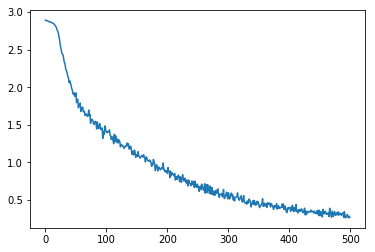

In [79]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses[1:])

In [80]:
def predict_max(model, X):
    hidden = model.initHidden()
    y_score, hidden = model(X, hidden)
    
    return torch.max(y_score, 2)[1][0]

In [81]:
def calc_accuracy(model, num_samples=10000):
    num_corrects = 0
    for i in range(num_samples):
        category, line, category_tensor, line_tensor = randomTrainingExample()
        #print(line)
        y_pred = predict_max(model, line_tensor)
        #print(f'y_pred:{y_pred}, y:{category_tensor}')
        num_corrects += (category_tensor.item() == y_pred.item())
        
    return num_corrects/num_samples
        

In [82]:
calc_accuracy(rnn)

0.9112

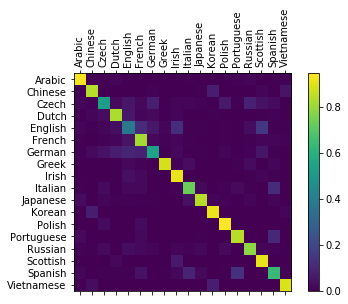

In [64]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()    
    output, hidden = rnn(line_tensor, hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.figure(figsize=(10,8))
plt.show()

In [83]:
output = evaluate(lineToTensor('Dovesky'))

In [84]:
output

tensor([[[ -4.2698,  -8.0661,   9.5016,  -0.0659,  10.7596,   2.7718,
            4.2901,   3.2301,   5.6978,  -2.9570,   0.0059,  -6.3147,
            1.3313, -13.6175,  14.3554,   2.3942,  -6.7266, -13.6766]]])

In [85]:
output.shape

torch.Size([1, 1, 18])

In [86]:
topv, topi = output.topk(3, 2, True)

In [87]:
topv[0,0][0]

tensor(14.3554)

In [88]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 2, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0,0][i].item()
            category_index = topi[0,0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Dovesky')
predict('Jackson')
predict('Satoshi')


> Dovesky
(14.36) Russian
(10.76) English
(9.50) Czech

> Jackson
(13.04) English
(11.70) Scottish
(7.82) German

> Satoshi
(11.84) Japanese
(9.17) Italian
(8.28) Arabic


In [89]:
predict('Fan')


> Fan
(8.83) Chinese
(5.81) Vietnamese
(5.29) Dutch


In [90]:
predict('Wang')


> Wang
(10.09) Korean
(8.49) Chinese
(7.44) German


In [91]:
predict('Qin')


> Qin
(10.97) Chinese
(7.65) Korean
(3.16) Vietnamese


In [92]:
predict('Chong')


> Chong
(11.64) Korean
(9.27) Chinese
(3.91) Czech


In [93]:
predict('Lam')


> Lam
(8.13) Vietnamese
(7.17) Chinese
(4.19) Dutch


In [94]:
predict('Huo')


> Huo
(11.01) Chinese
(6.89) Korean
(6.02) Vietnamese


In [95]:
predict('Zhou')


> Zhou
(11.72) Chinese
(5.27) Korean
(2.76) German


In [106]:
predict('Zheng')


> Zheng
(13.19) Chinese
(6.77) English
(6.09) Korean
